# 1. Introduction
This notebook performs heart disease classification using the K-Nearest Neighbors (KNN) algorithm.
We load and clean data from multiple sources, preprocess features, and evaluate the model performance.

# 2. Load data

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define paths and format types
file_info = [
    ('heart+disease/processed.cleveland.data', False),
    ('heart+disease/processed.va.data', False),
    ('heart+disease/processed.switzerland.data', False),
    ('heart+disease/reprocessed.hungarian.data', True),
]

dataframes = []
for path, is_space_separated in file_info:
    df = pd.read_csv(path, sep=r'\s+' if is_space_separated else ',', header=None)
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)

# 2.1 Feature Overview


1. age – Age of the person
2. sex – Sex (1 = male, 0 = female)
3. cp – Chest pain type (0–3, categorical)
4. stbps – Resting blood pressure
5. l – Serum cholesterol
6. fbs – Fasting blood sugar > 120 mg/dl (1 = yes, 0 = no)
7. restecg – Resting electrocardiographic results (0–2)
8. thalach – Maximum heart rate achieved
9. exang – Exercise-induced angina (1 = yes, 0 = no)
10. oldpeak – ST depression induced by exercise
11. slope – Slope of the peak exercise ST segment (0–2)
12. ca – Number of major vessels colored by fluoroscopy (0–3)
13. thal – Thalassemia (0–3, encoded)
14. target – Target variable (0 = no heart disease, 1 = heart disease)

# 3. Clean Data

In [9]:
# Replace '?' with NaN and drop incomplete rows
data.replace('?', np.nan, inplace=True)
data.dropna(inplace=True)

# 4. Extract Features and Labels

In [10]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1].astype(int)
y = y.apply(lambda val: 1 if val > 0 else 0)

# Preview processed data
prepared_data = X.copy()
prepared_data['target'] = y
display(prepared_data.head(10))

,0,1,2,3,4,5,6,7,8,9,10,11,12,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,1
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,1
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1


# 5. Train/Test Split and Scaling

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 6. Train and Evaluate KNN

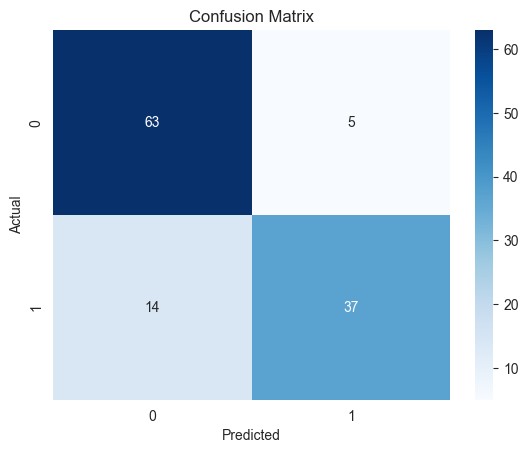

Accuracy: 0.8403361344537815
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87        68
           1       0.88      0.73      0.80        51

    accuracy                           0.84       119
   macro avg       0.85      0.83      0.83       119
weighted avg       0.85      0.84      0.84       119



In [12]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# 7. Optimize k Value

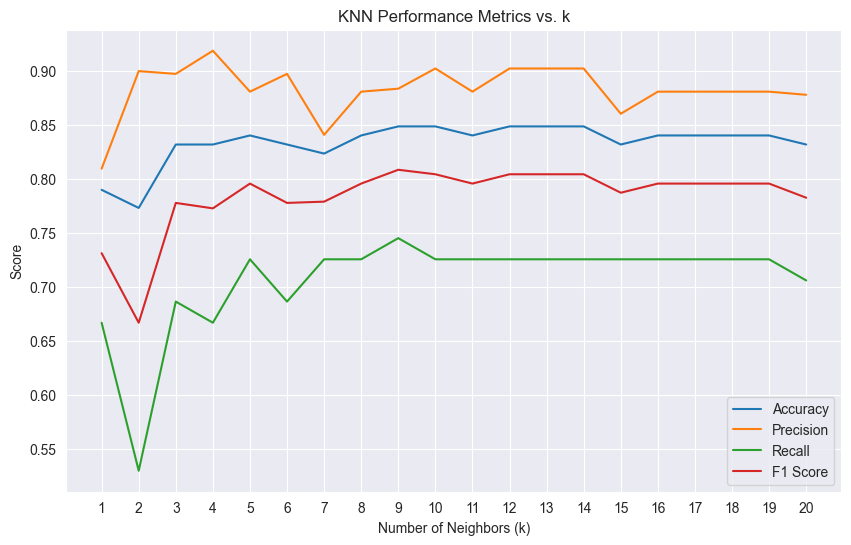

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

k_range = range(1, 21)
accuracies, precisions, recalls, f1s = [], [], [], []

for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(k_range, accuracies, label='Accuracy')
plt.plot(k_range, precisions, label='Precision')
plt.plot(k_range, recalls, label='Recall')
plt.plot(k_range, f1s, label='F1 Score')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Score')
plt.title('KNN Performance Metrics vs. k')
plt.legend()
plt.grid(True)
plt.xticks(k_range)
plt.show()